# IPCC AR6 Interactive Atlas Datalab

***

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Projected climate change signals and uncertainty under global warming levels

**M. Iturbide** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook is a reproducibility example for the [**IPCC-WGI AR6 Interactive Atlas**](https://interactive-atlas.ipcc.ch/) products. 

This notebook works with the data available in this Hub. In particular, the **IPCC-WGI AR6 Interactive Atlas Dataset**, originally published at [**DIGITAL.CSIC**](https://digital.csic.es/handle/10261/280324) for the long-term archival, and also available through the **[Copernicus Data Store (CDS)](https://cds.climate.copernicus.eu/datasets/projections-climate-atlas?tab=overview)**.

Open the **`Getting_started.ipynb`** for a **description of the available data** and for a quick **introduction to the **[climate4R framework](https://github.com/SantanderMetGroup/climate4R)**, the bundle of R packages used in this notebook.


### Contents in this notebook
1) Libraries
2) The Global Warming Level analysis dimension
3) Data loading for the different GWLs
4) Data loading for the historical reference
5) Uncertainty calculation and representation
***

Before we start, or at any stage of the notebook, we can customize the plotting area within this notebook as follows:

In [ ]:
library(repr)
# Change plot size 
options(repr.plot.width=18, repr.plot.height=8)

***

### 1. Libraries

The core ***climate4R*** libraries that allow for **data loading, transformation** (e.g. spatio-temporal aggregations), and **visualization** are `loadeR`, `transformeR` and `visualizeR`. In this example notebook we will also use the `geoprocessoR` package to perform spatial operations.

We will also use other useful libraries; the plotting library `lattice`, `RColorBrewer` for selecting color palettes, and the `magrittr` library for piping operations (through `%>%`).

In [ ]:
library(loadeR)
library(transformeR)
library(visualizeR)
library(geoprocessoR)
library(rgdal)
library(lattice)
library(magrittr)
library(RColorBrewer)
#library(Rcurl)

### 2. The Global Warming Level analysis dimension

Instead of calculating climate change anomalies over a fixed period, we will compute the anomaly based on a specific level of global warming (GWL). To achieve this, we need the information on the **time windows during which global surface temperature reaches various levels of warming**. These time windows vary across Global Climate Models (GCMs).

This data is available at the [**IPCC-WGI/Atlas GitHub repository**](https://github.com/IPCC-WG1/Atlas/tree/main/warming-levels). Specifically, we require the information in the `CMIP6_Atlas_WarmingLevels.csv` file, as we will be working with climate projections from CMIP6.

We can read the file remotely as follows:

In [3]:
url <- "https://github.com/SantanderMetGroup/ATLAS/raw/refs/heads/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv"
gwls <- read.csv(url)
str(gwls)

'data.frame':	35 obs. of  17 variables:
 $ model_run  : chr  "ACCESS-CM2_r1i1p1f1" "ACCESS-ESM1-5_r1i1p1f1" "AWI-CM-1-1-MR_r1i1p1f1" "BCC-CSM2-MR_r1i1p1f1" ...
 $ X1.5_ssp126: int  2027 2030 2022 2041 NA 2013 2026 2021 2023 2027 ...
 $ X2_ssp126  : int  2042 2072 2050 NA NA 2025 2042 2038 2037 2058 ...
 $ X3_ssp126  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ X4_ssp126  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ X1.5_ssp245: int  2028 2029 2020 2035 2055 2012 2028 2024 2024 2030 ...
 $ X2_ssp245  : int  2040 2045 2039 2057 2088 2023 2042 2039 2038 2048 ...
 $ X3_ssp245  : int  2070 NA NA NA NA 2049 2078 2075 2066 2084 ...
 $ X4_ssp245  : int  NA NA NA NA NA 2083 NA NA NA NA ...
 $ X1.5_ssp370: int  2027 2033 2021 2032 2046 2012 2030 2027 2025 2032 ...
 $ X2_ssp370  : int  2039 2048 2037 2046 2065 2023 2043 2041 2039 2045 ...
 $ X3_ssp370  : int  2062 2069 2064 2074 NA 2043 2068 2063 2063 2066 ...
 $ X4_ssp370  : int  2082 NA NA NA NA 2059 2087 2085 2087 2083 ...
 $ X1.5_ssp585: int  2

In this example, we will focus on the **+3ºC GWL**. We will use the `ssp585` scenario, though any other scenario could be used, as the anomalies do not vary significantly across scenarios when analyzed through the GWL framework.

In [4]:
gwl3 <- gwls[,c("model_run", "X3_ssp585")] %>% print

                   model_run X3_ssp585
1        ACCESS-CM2_r1i1p1f1      2055
2     ACCESS-ESM1-5_r1i1p1f1      2060
3     AWI-CM-1-1-MR_r1i1p1f1      2059
4       BCC-CSM2-MR_r1i1p1f1      2065
5       CAMS-CSM1-0_r2i1p1f1      2088
6           CanESM5_r1i1p1f1      2040
7             CESM2_r4i1p1f1      2055
8       CESM2-WACCM_r1i1p1f1      2053
9      CMCC-CM2-SR5_r1i1p1f1      2052
10       CNRM-CM6-1_r1i1p1f2      2058
11    CNRM-CM6-1-HR_r1i1p1f2      2051
12      CNRM-ESM2-1_r1i1p1f2      2064
13        EC-Earth3_r1i1p1f1      2057
14    EC-Earth3-Veg_r1i1p1f1      2050
15 EC-Earth3-Veg-LR_r1i1p1f1      9999
16        FGOALS-g3_r1i1p1f1      2072
17         GFDL-CM4_r1i1p1f1      2059
18        GFDL-ESM4_r1i1p1f1      2075
19  HadGEM3-GC31-LL_r1i1p1f3      2047
20         IITM-ESM_r1i1p1f1      2075
21        INM-CM4-8_r1i1p1f1      2069
22        INM-CM5-0_r1i1p1f1      2074
23     IPSL-CM6A-LR_r1i1p1f1      2050
24       KACE-1-0-G_r2i1p1f1      2042
25        KIOST-ESM_r1i1p

The object `gwl3` is a data frame that contains the **central year within a 20-year time window during which the +3ºC GWL is reached for each model**. For more information, refer to the [IPCC-WGI/Atlas repository](https://github.com/IPCC-WG1/Atlas/tree/main/warming-levels).

### 3. Data loading for the different GWLs

To load the data, we first need to determine the path of the file containing the specific data we require. This path can point to either a NetCDF file or a NcML catalog file. The available paths are listed in the **data_inventory.csv** file. We can read this information with function `read.csv` and apply `str` for a quick overview of the content:

In [5]:
data.paths <- read.csv("../../data_inventory.csv")
str(data.paths)

'data.frame':	1726 obs. of  6 variables:
 $ location  : chr  "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CORDEX-ANT/historical/pr_CORDEX-ANT_histo"| __truncated__ "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CORDEX-ANT/historical/tn_CORDEX-ANT_histo"| __truncated__ "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CORDEX-ANT/historical/rx1day_CORDEX-ANT_h"| __truncated__ "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CORDEX-ANT/historical/tx_CORDEX-ANT_histo"| __truncated__ ...
 $ type      : chr  "opendap" "opendap" "opendap" "opendap" ...
 $ variable  : chr  "pr" "tn" "rx1day" "tx" ...
 $ project   : chr  "CORDEX-ANT" "CORDEX-ANT" "CORDEX-ANT" "CORDEX-ANT" ...
 $ experiment: chr  "historical" "historical" "historical" "historical" ...
 $ frequency : chr  "mon" "mon" "mon" "mon" ...


* `location` refers to the path 
* `type` refers to the access mode, local (netcdf) or remote (opendap). 
* `variable` referst to the climatic variable or index (i.e. tas, pr, tn, rx1day, etc.)
* `project` refers to the project coordinating the datasets (i.e. CORDEX-EUR, CMIP5, CMIP6, etc.)
* `experiment` referst to the scenario (i.e. historical, rcp26, ssp126, rcp85, etc.)

We can easily apply filters to narrow down to the desired file:

In [6]:
filtered.path <- subset(data.paths, project == "CMIP6" & variable == "pr" & experiment == "ssp585")
filtered.path

,location,type,variable,project,experiment,frequency
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
77,https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/pr_CMIP6_ssp585_mon_201501-210012.nc,opendap,pr,CMIP6,ssp585,mon
940,/home/jovyan/shared/data/IPCC-WGI_AR6_Interactive_Atlas_Dataset/CMIP6/ssp585/pr_CMIP6_ssp585_mon_201501-210012.nc,netcdf,pr,CMIP6,ssp585,mon


As shown in the resulting table, we have two versions (`type`) of the dataset. The first version is accessed via OPeNDAP through THREDDS, while the second version is located in the `shared` directory of this Hub and can be accessed directly. In this example, we will choose the second option.

In [7]:
nc.file <- subset(filtered.path, type == "opendap")[["location"]]

Before data loading do an inventory of the data using the `dataInventory` function:

In [8]:
nc.file

[1] "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/pr_CMIP6_ssp585_mon_201501-210012.nc"

In [9]:
di <- dataInventory(nc.file)
str(di)

[2024-11-07 17:32:49.41048] Doing inventory ...

[2024-11-07 17:32:49.482652] Opening dataset...

[2024-11-07 17:32:50.573177] The dataset was successfuly opened

[2024-11-07 17:32:50.9083] Retrieving info for 'pr' (0 vars remaining)

[2024-11-07 17:32:50.981614] Done.



List of 1
 $ pr:List of 7
  ..$ Description: chr "Monthly mean of daily accumulated precipitation"
  ..$ DataType   : chr "float"
  ..$ Shape      : int [1:4] 33 1032 180 360
  ..$ Units      : chr "mm"
  ..$ DataSizeMb : num 8827
  ..$ Version    : logi NA
  ..$ Dimensions :List of 4
  .. ..$ member:List of 3
  .. .. ..$ Type  : chr "Ensemble"
  .. .. ..$ Units : chr ""
  .. .. ..$ Values: chr [1:33] "CSIRO-ARCCSS_ACCESS-CM2_r1i1p1f1" "CSIRO_ACCESS-ESM1-5_r1i1p1f1" "BCC_BCC-CSM2-MR_r1i1p1f1" "CAMS_CAMS-CSM1-0_r2i1p1f1" ...
  .. ..$ time  :List of 4
  .. .. ..$ Type      : chr "Time"
  .. .. ..$ TimeStep  : chr "30.436 days"
  .. .. ..$ Units     : chr "days since 1850-01-01 00:00:00"
  .. .. ..$ Date_range: chr "2015-01-01T00:00:00Z - 2100-12-01T00:00:00Z"
  .. ..$ lat   :List of 5
  .. .. ..$ Type       : chr "Lat"
  .. .. ..$ Units      : chr "degrees_north"
  .. .. ..$ Values     : num [1:180] -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 ...
  .. .. ..$ Shape      : 

The result includes information about the units, variables, dimensions, and more. Since we are working with warming levels and need to load a different period of years for each model, we will first extract the information about the members from the inventory. This information is essential to match the GWL array obtained earlier. In other words, we need to create an index object that provides the model position in the data for each row in the `gwl3` object. We can achieve this using the `grep` function in a loop.

In [10]:
ind <- lapply(gwl3$model_run, grep, x = di$pr$Dimensions$member$Values) 

This index (`ind`) will enable us to load the data for each model separately, requesting a different 20-year time period each time. Before loading the data, we can set common parameters such as the geographical domain, the target season (boreal winter in this example), and the reference historical baseline (in this case, the pre-industrial period) for simplicity.

In [11]:
ref.period <- 1850:1900
lonLim <- c(-11, 35)
latLim <- c(35, 72)
season <- c(12, 1, 2)

We will now **apply the `loadGridData` function within a `lapply` loop** to obtain a list of *climate4R* grids, where each slot represents a grid corresponding to a particular model. For a detailed explanation of what a *climate4R* grid is, please open the **`Getting_started.ipynb`** notebook.

**The GWL period for each model is passed to the `loadGridData` function** using the expression `(gwl3$X3_ssp585[x]-9):(gwl3$X3_ssp585[x]+10)`, which generates a 20-year vector starting from the central year minus 9 years and ending at the central year plus 10 years (the central years are defined in the `gwl3` object created earlier).

We also introduce a `tryCatch` expression to prevent the loop from being interrupted in cases where models do not reach the global warming level (GWL) within the current century. Additionally, we pipe the `suppressMessages` function to minimize lengthy output logs. This **loading process can take a few minutes** and varies depending on the region and period requested.

Note that **if fixed periods are considered for the analysis, the process becomes much simpler** because a loop is unnecessary, as the period to be loaded is common to all models. Please open the **`Getting_started.ipynb`** notebook for a simple example using fixed periods for the analysis.

In [12]:
cmip6.ssp585.l <- lapply(1:length(ind), function(x) {
    loadGridData(dataset = nc.file,
                 var = "pr",
                 lonLim = lonLim, 
                 latLim = latLim,
                 years = (gwl3$X3_ssp585[x]-9):(gwl3$X3_ssp585[x]+10),
                 season = season,
                 members = ind[[x]]) %>% 
        tryCatch(error = function(x) message("no data for this member and variable")) 
    }) %>% suppressMessages

We can eliminate the "no data" slots in the list as follows:

In [13]:
nodata.members <- lapply(cmip6.ssp585.l, is.null) %>% unlist %>% which
cmip6.ssp585.l <- cmip6.ssp585.l[-nodata.members]

In the next code chunk, we perform an annual aggregation of the variable. Additionally, we generate a time-series plot to illustrate the concept of GWLs, where each model spans a different time period. The `temporalPlot` function calculates the spatial mean by default 

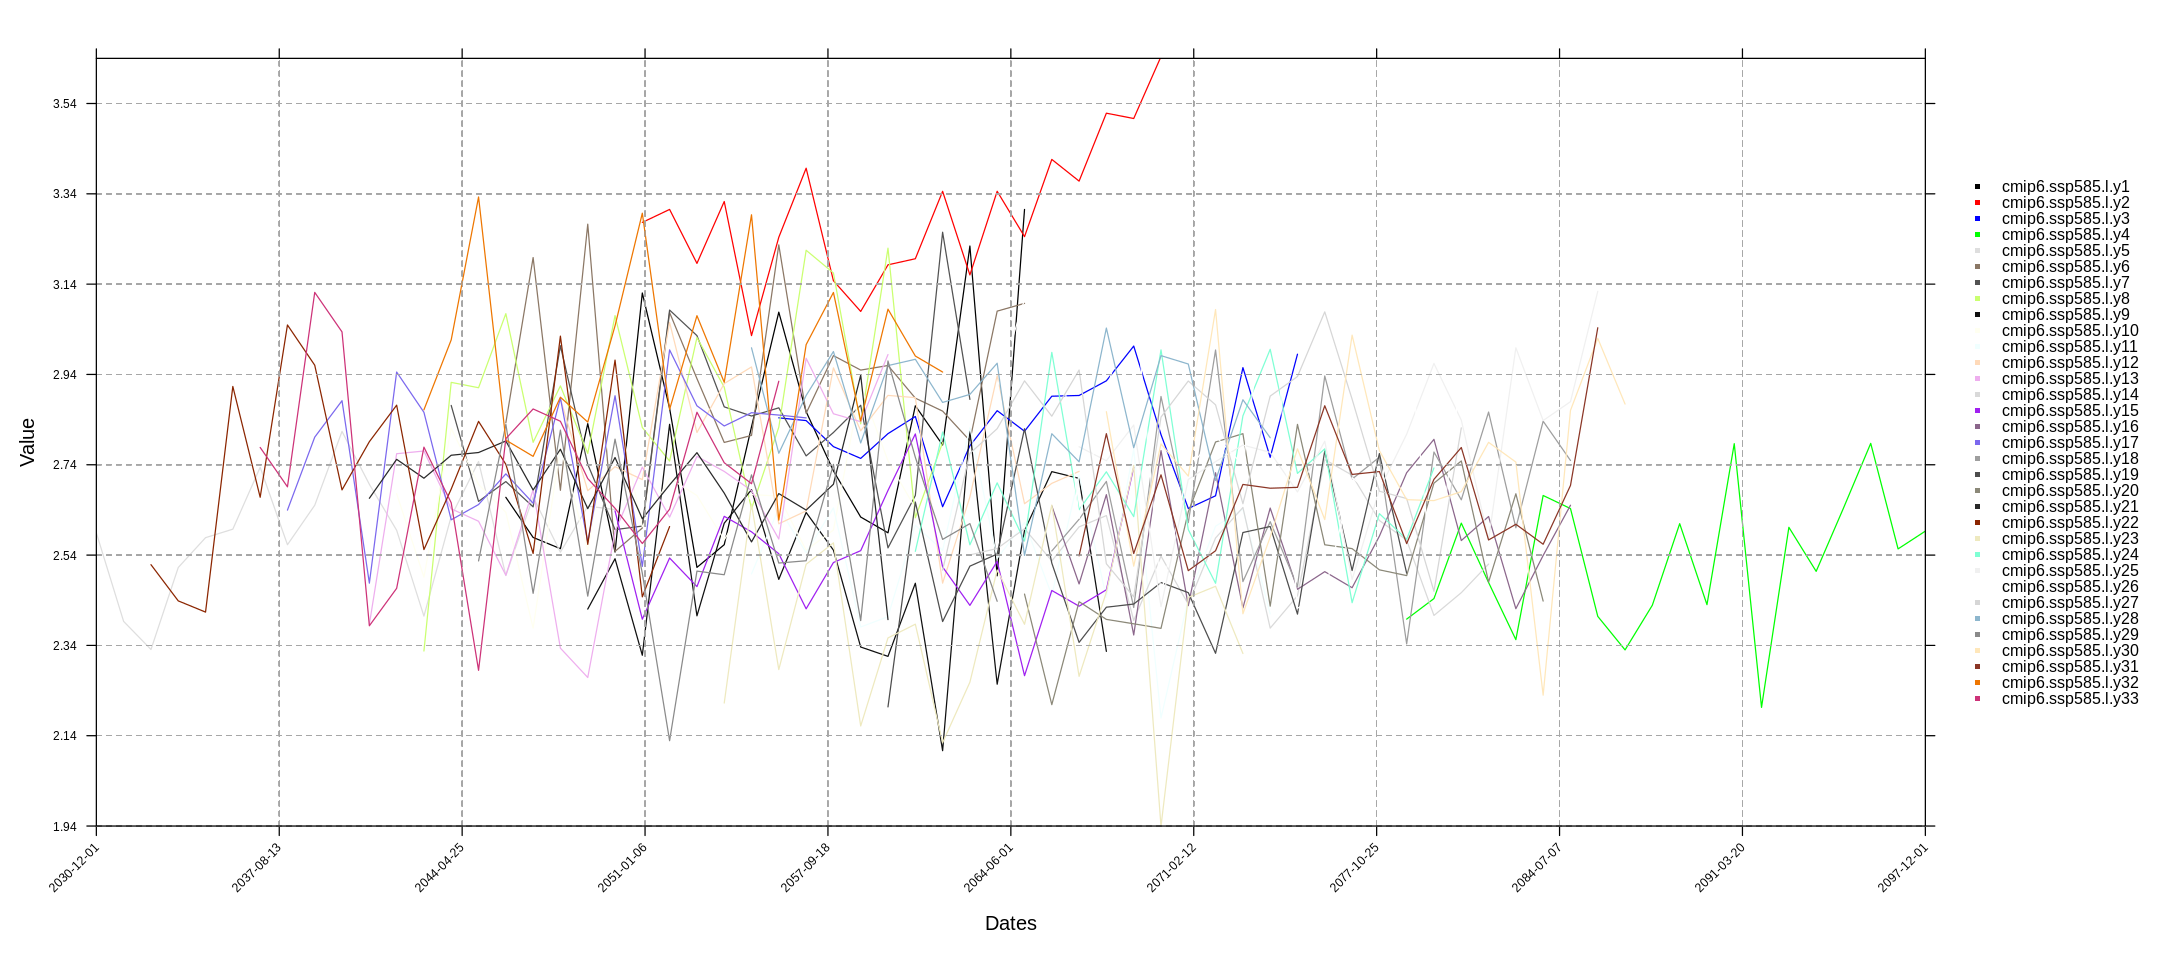

In [14]:
cmip6.ssp585.l.y <- lapply(cmip6.ssp585.l, aggregateGrid, aggr.y = list(FUN = "mean", na.rm = TRUE)) %>% suppressMessages
temporalPlot(cmip6.ssp585.l.y) %>% suppressMessages

To simplify the rest of the analysis, let's combine all models into the same grid. We can achieve this by applying the `bindGrid` function and setting the `skip.temporal.check` parameter to `TRUE`, as each model covers a different time period.

In [15]:
cmip6.ssp585 <- bindGrid(cmip6.ssp585.l, dimension = "member", skip.temporal.check = TRUE)

Now we plot the map of the climatologies (mean of the period; 20-year means in this case) using the `climatology` and `spatialPlot` functions. The `climatology` function calculates the mean by default, though other functions can be specified to perform different aggregations over the period.

In the resulting plot, each panel represents a CMIP6 member (a model). Note that we previously set the plotting window space in Jupyter.

[2024-11-07 17:37:10.96559] - Computing climatology...

[2024-11-07 17:37:11.27891] - Done.



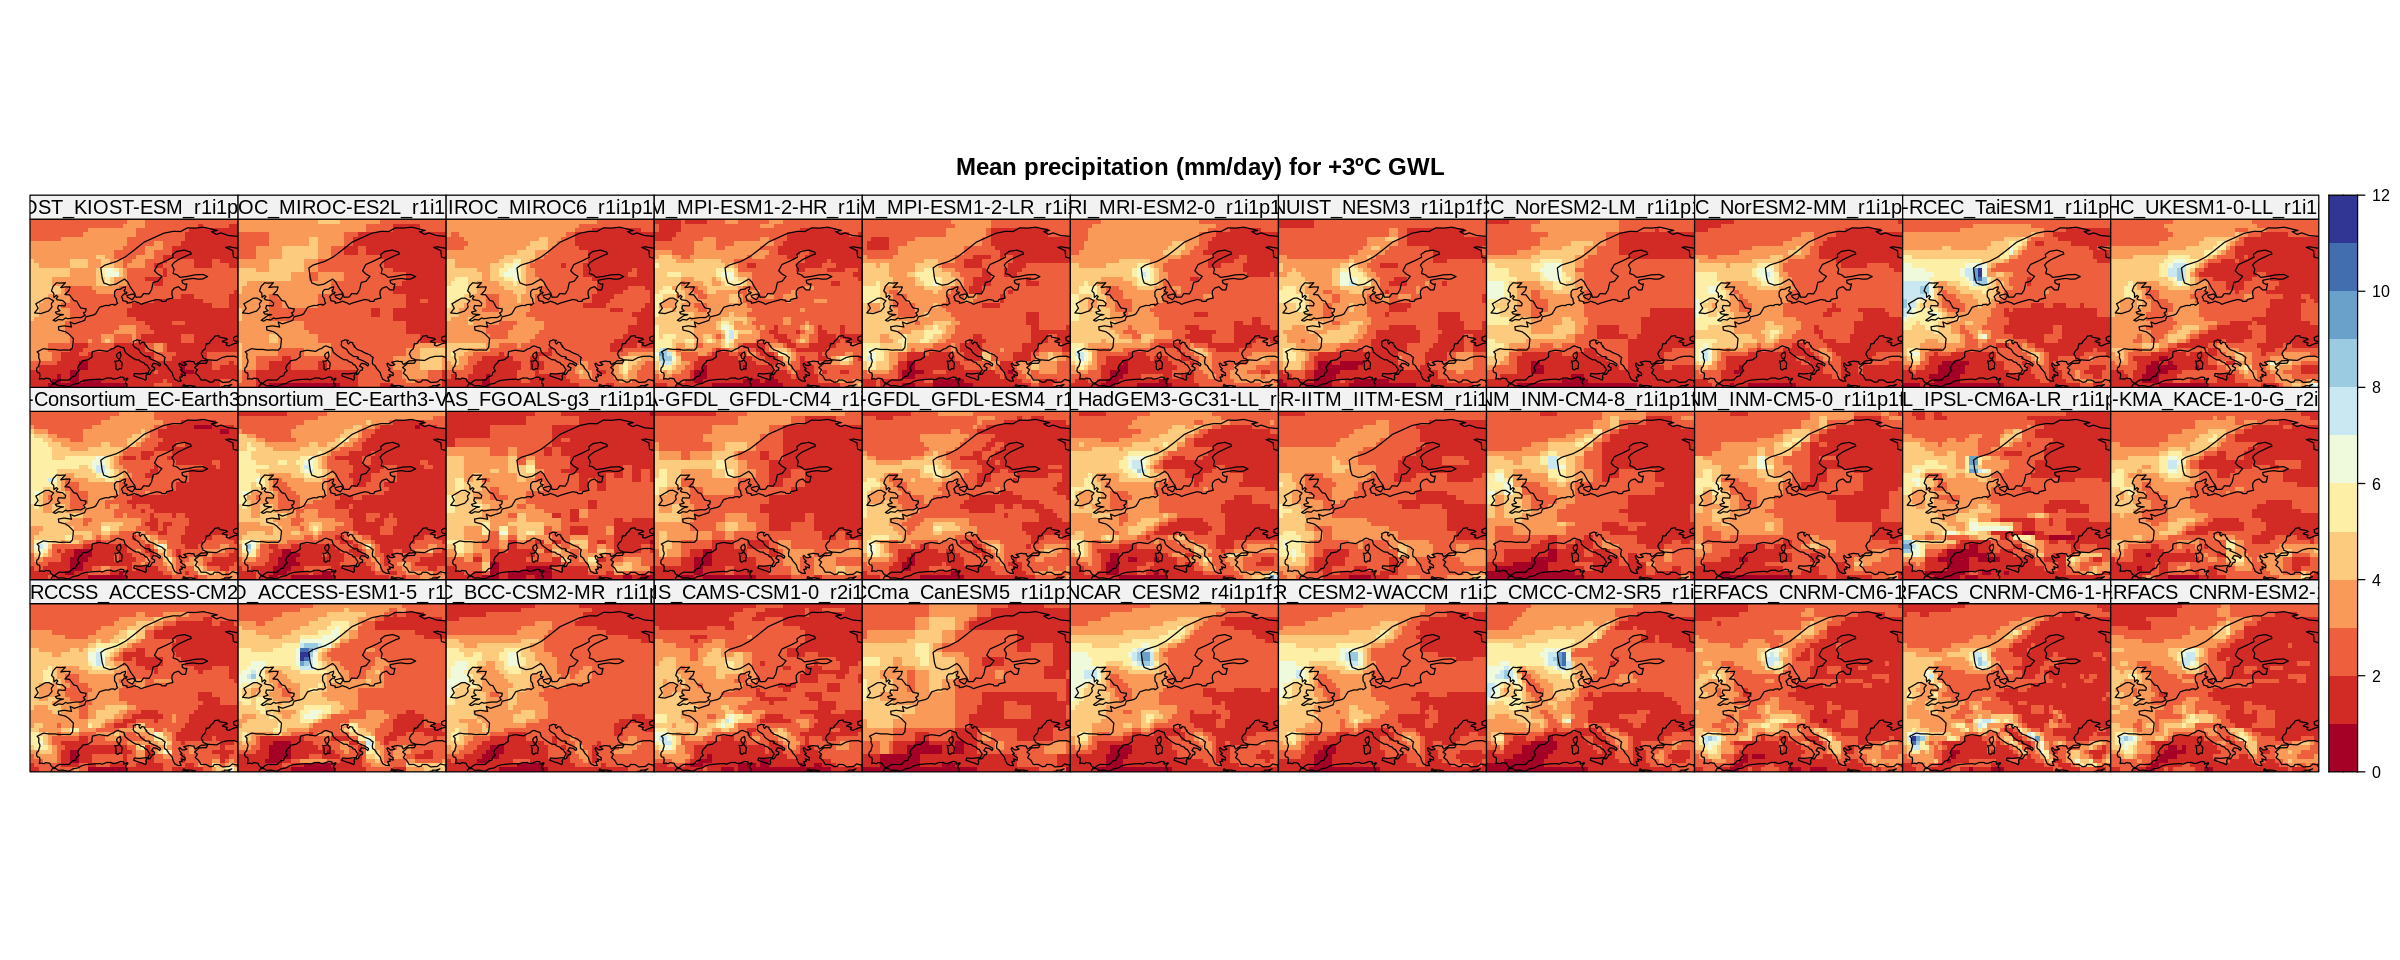

In [16]:
options(repr.plot.width=20, repr.plot.height=8)
spatialPlot(climatology(cmip6.ssp585), 
            backdrop.theme = "coastline", 
            at = seq(0, 12),
            set.max = 12, set.min = 0,
            layout = c(11, 3),
            main = "Mean precipitation (mm/day) for +3ºC GWL",
            strip = strip.custom(factor.levels = cmip6.ssp585$Members))

### 4. Data loading for the historical reference

To get the climate change signal, we first need to load data from the historical scenario. To do this we repeat the filtering process to get the required NetCDF path. 

In [17]:
nc.file.hist <- subset(data.paths, project == "CMIP6" & variable == "pr" & experiment == "historical" & type == "opendap")[["location"]] %>% 
                        print

[1] "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/historical/pr_CMIP6_historical_mon_185001-201412.nc"


As mentioned above, we are considering the pre-industrial period (defined earlier in object `ref.period`). In this case, the reference period is common to all models, therefore, the process becomes simpler; all models are loaded at once into a single grid object and we do not need to set a loop. 

In [18]:
cmip6.hist <- loadGridData(nc.file.hist, 
                         var = "pr", 
                         lonLim = lonLim, latLim = latLim,
                         years = ref.period, 
                         season = season)  %>% suppressWarnings

[2024-11-07 17:37:15.249912] Opening dataset...

[2024-11-07 17:37:15.608935] The dataset was successfuly opened

[2024-11-07 17:37:15.612853] Defining geo-location parameters

[2024-11-07 17:37:15.667105] Defining time selection parameters

[2024-11-07 17:37:15.691077] Retrieving data subset ...

[2024-11-07 17:37:35.043471] Done



Before continuing, we must retain the same models (in the same order) in both the future and historical grids. To do so, we apply the `intersectGrid` function. 

In [19]:
cmip6.common.mems <- intersectGrid(cmip6.hist, cmip6.ssp585, type = "members", which.return = 1:2)
cmip6.hist <- cmip6.common.mems[[1]] ; cmip6.ssp585 <- cmip6.common.mems[[2]]

It is always a good practice to make sure that the members in both grids are identical:

In [20]:
identical(cmip6.hist$Members, cmip6.ssp585$Members)

[1] TRUE

Now we can calculate the anomaly by computing the difference between both climatologies. We can easily do this using the `climatology` and `gridArithmetics` functions. 

In [21]:
delta <- gridArithmetics(climatology(cmip6.ssp585), climatology(cmip6.hist), operator = "-")

[2024-11-07 17:37:35.743964] - Computing climatology...

[2024-11-07 17:37:36.055722] - Done.

[2024-11-07 17:37:36.122609] - Computing climatology...

[2024-11-07 17:37:36.861119] - Done.



Since the `delta` object results from an arithmetic operation between two climatologies it isn't necessary to apply the `climatology` function to plot the corresponding maps.

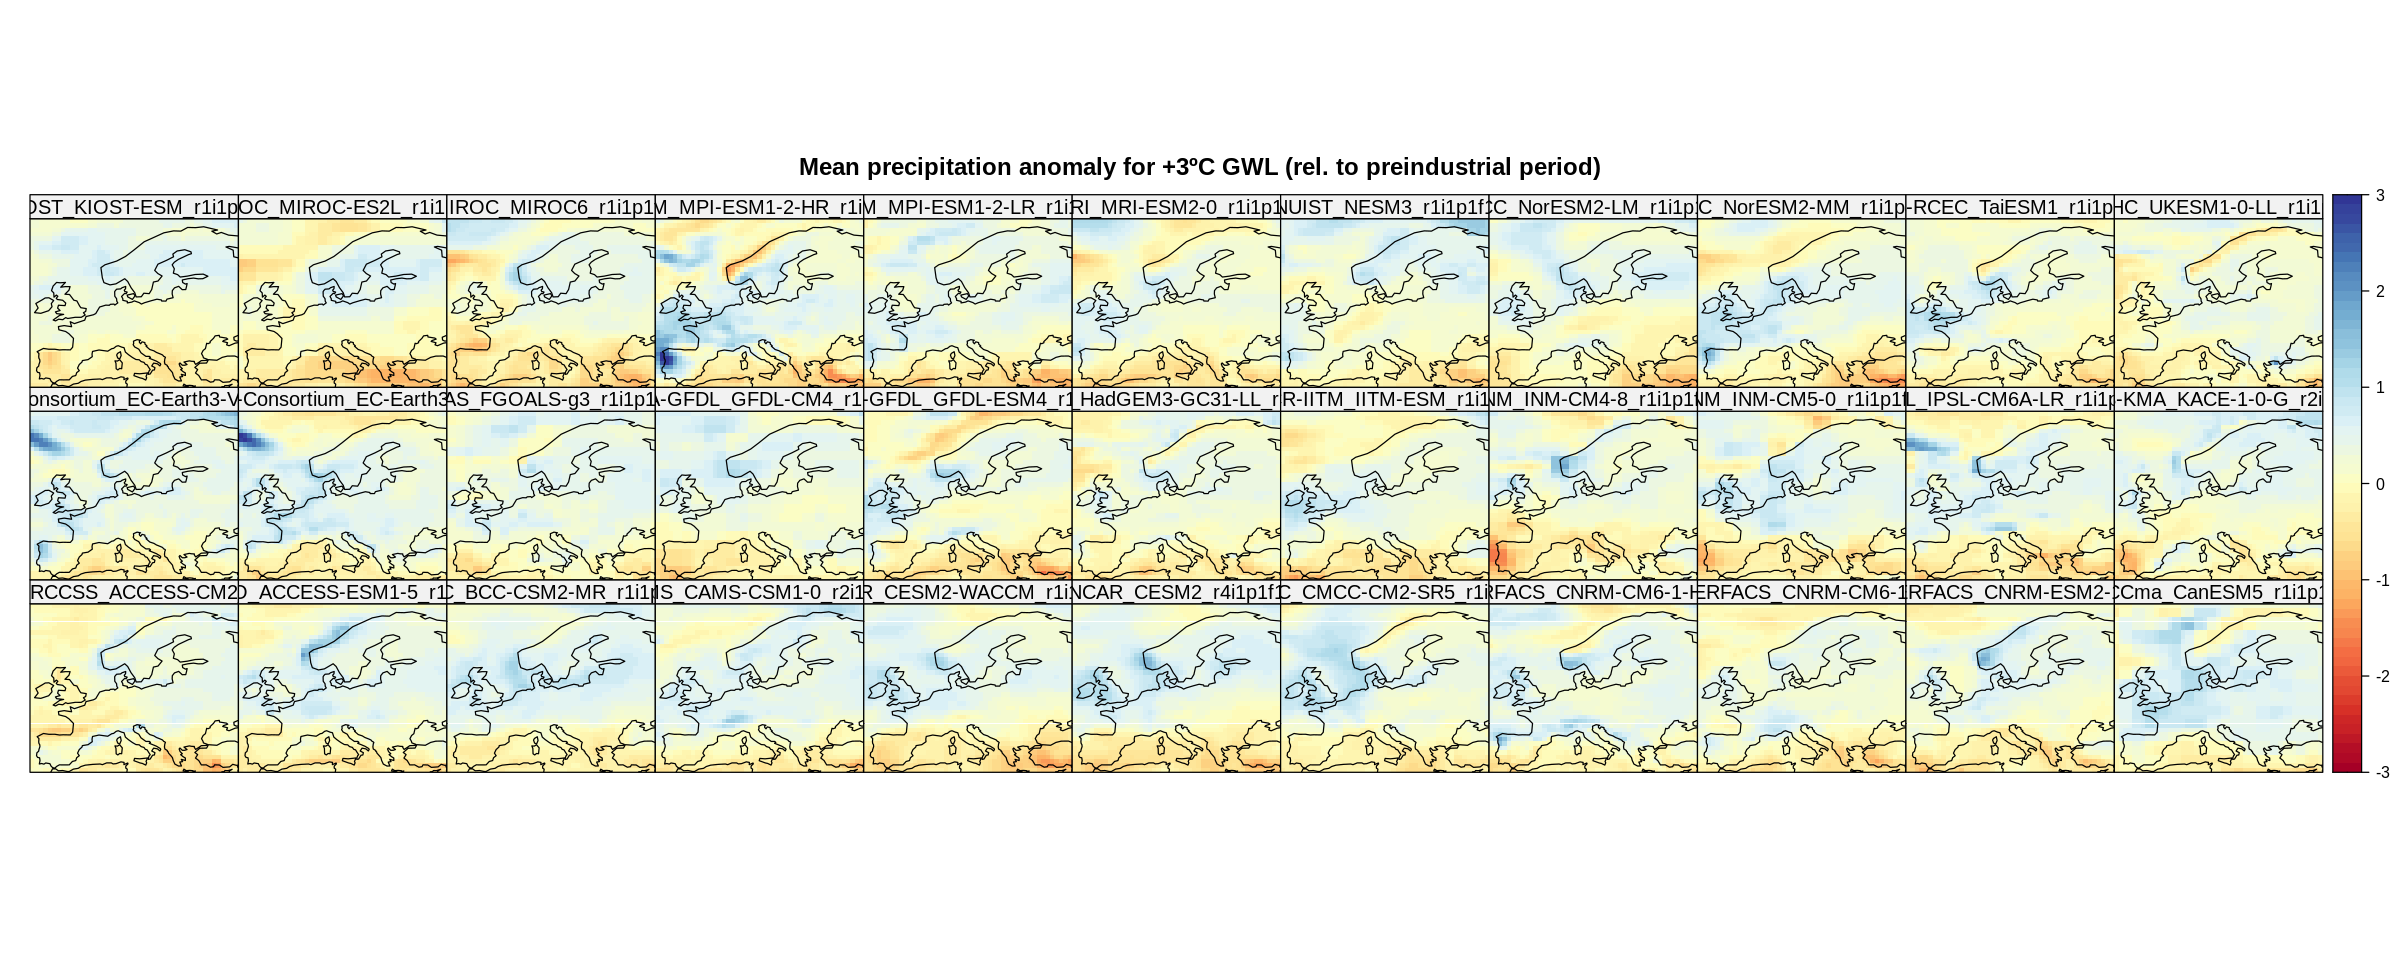

In [22]:
spatialPlot(delta, 
            backdrop.theme = "coastline", 
            at = seq(-3, 3, 0.1), 
            set.max = 3, set.min = -3,
            layout = c(11, 3),
            main = "Mean precipitation anomaly for +3ºC GWL (rel. to preindustrial period)",
            strip = strip.custom(factor.levels = delta$Members))

These maps represent the climate change signal as an absolute anomaly. We can calculate the relative anomaly as follows.

In [23]:
delta.rel <- gridArithmetics(delta, climatology(cmip6.hist), 100, operator = c("/", "*"))

[2024-11-07 17:37:40.414637] - Computing climatology...

[2024-11-07 17:37:41.170968] - Done.



To plot the resulting maps, we choose a specific Brewer palette, "BrBG" in this case (see the [ColorBrewer website](https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=3)).

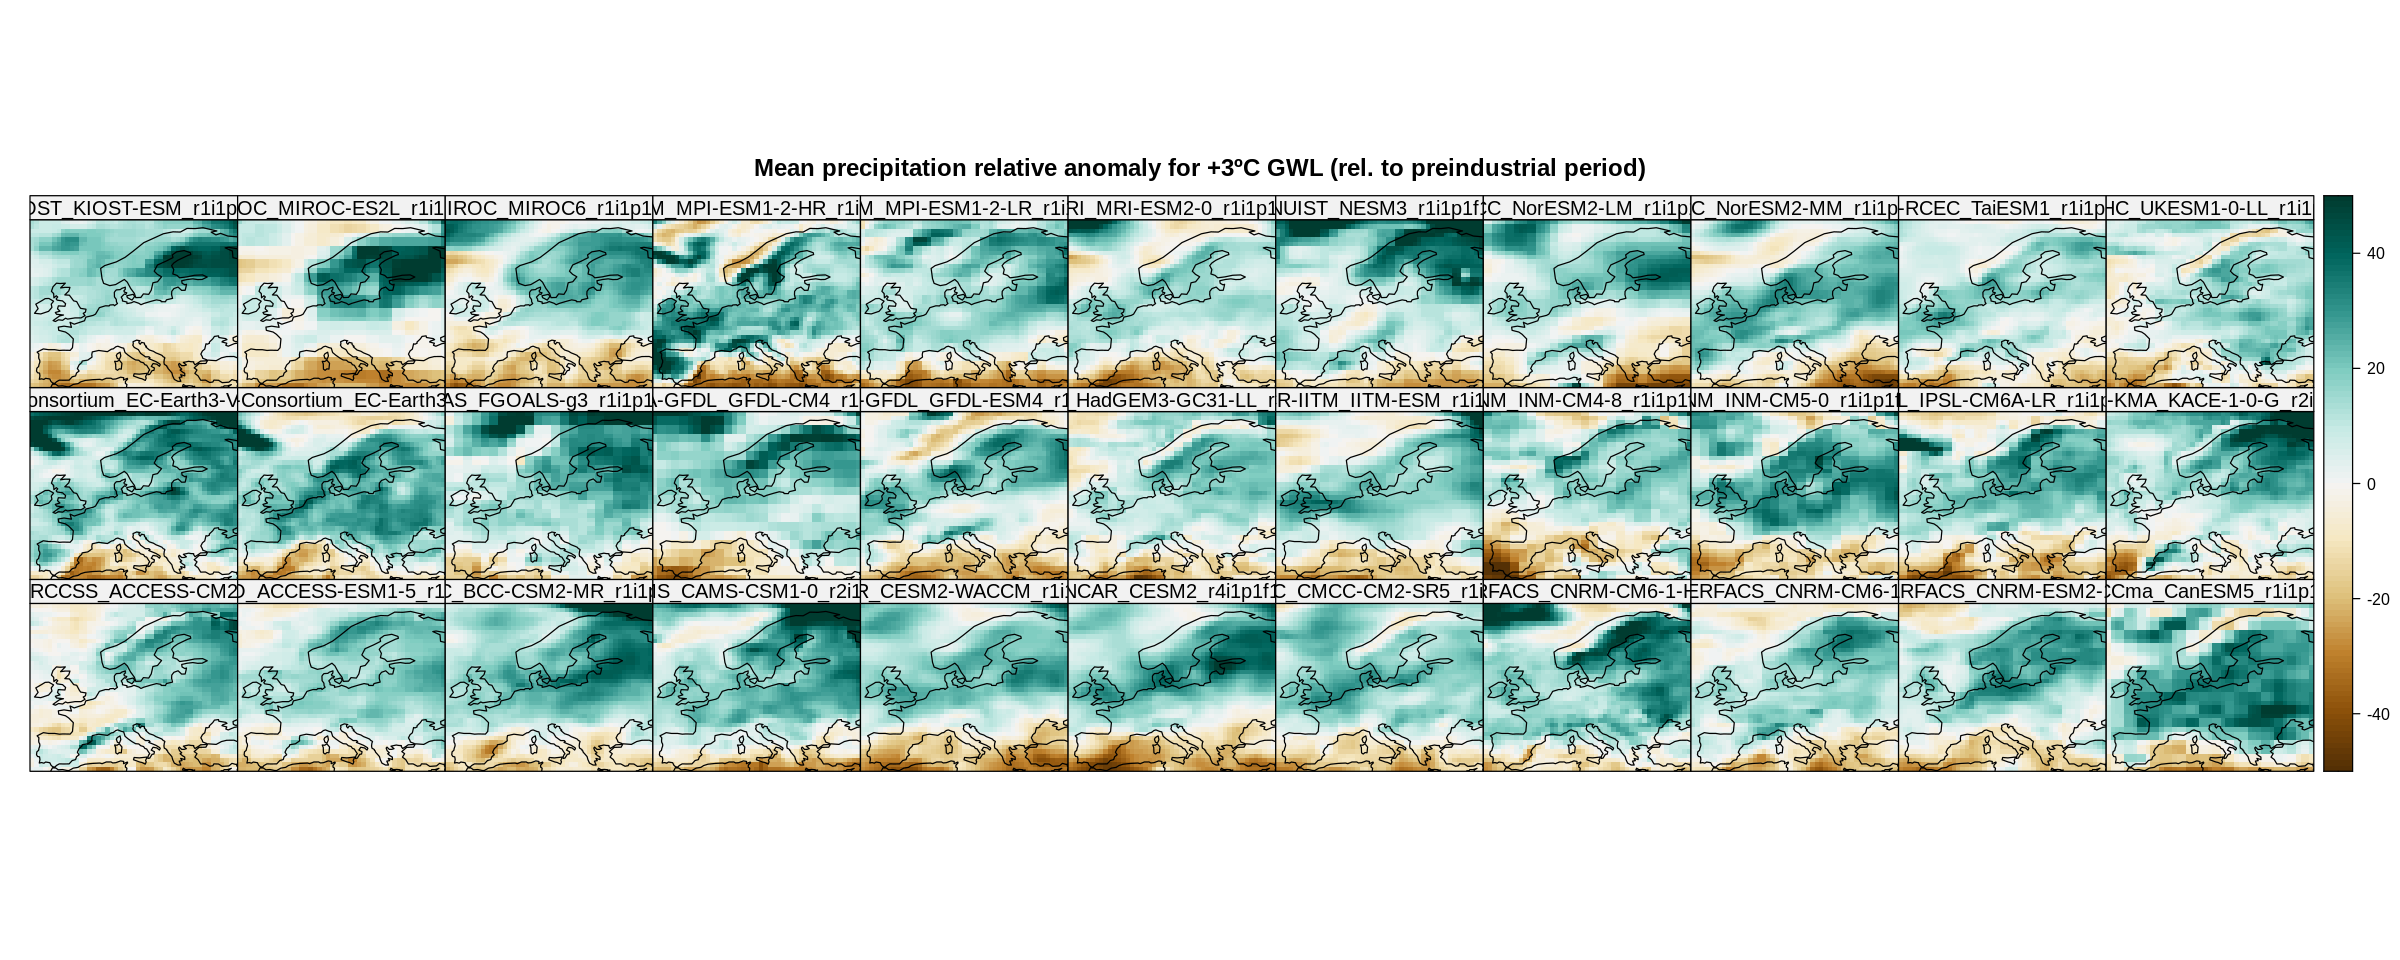

In [24]:
spatialPlot(delta.rel, 
            backdrop.theme = "coastline", 
            at = seq(-50, 50, 1), 
            set.max = 50, set.min = -50, 
            color.theme = "BrBG",
            layout = c(11, 3),
            main = "Mean precipitation relative anomaly for +3ºC GWL (rel. to preindustrial period)",
            strip = strip.custom(factor.levels = delta$Members))

To calculate the multi-model mean, use function `aggregateGrid`.

In [25]:
ens.mean <- aggregateGrid(delta.rel, aggr.mem = list(FUN = mean))

[2024-11-07 17:37:44.488236] - Aggregating members...

[2024-11-07 17:37:44.503029] - Done.



In [26]:
# Change plot size 
options(repr.plot.width=18, repr.plot.height=6)

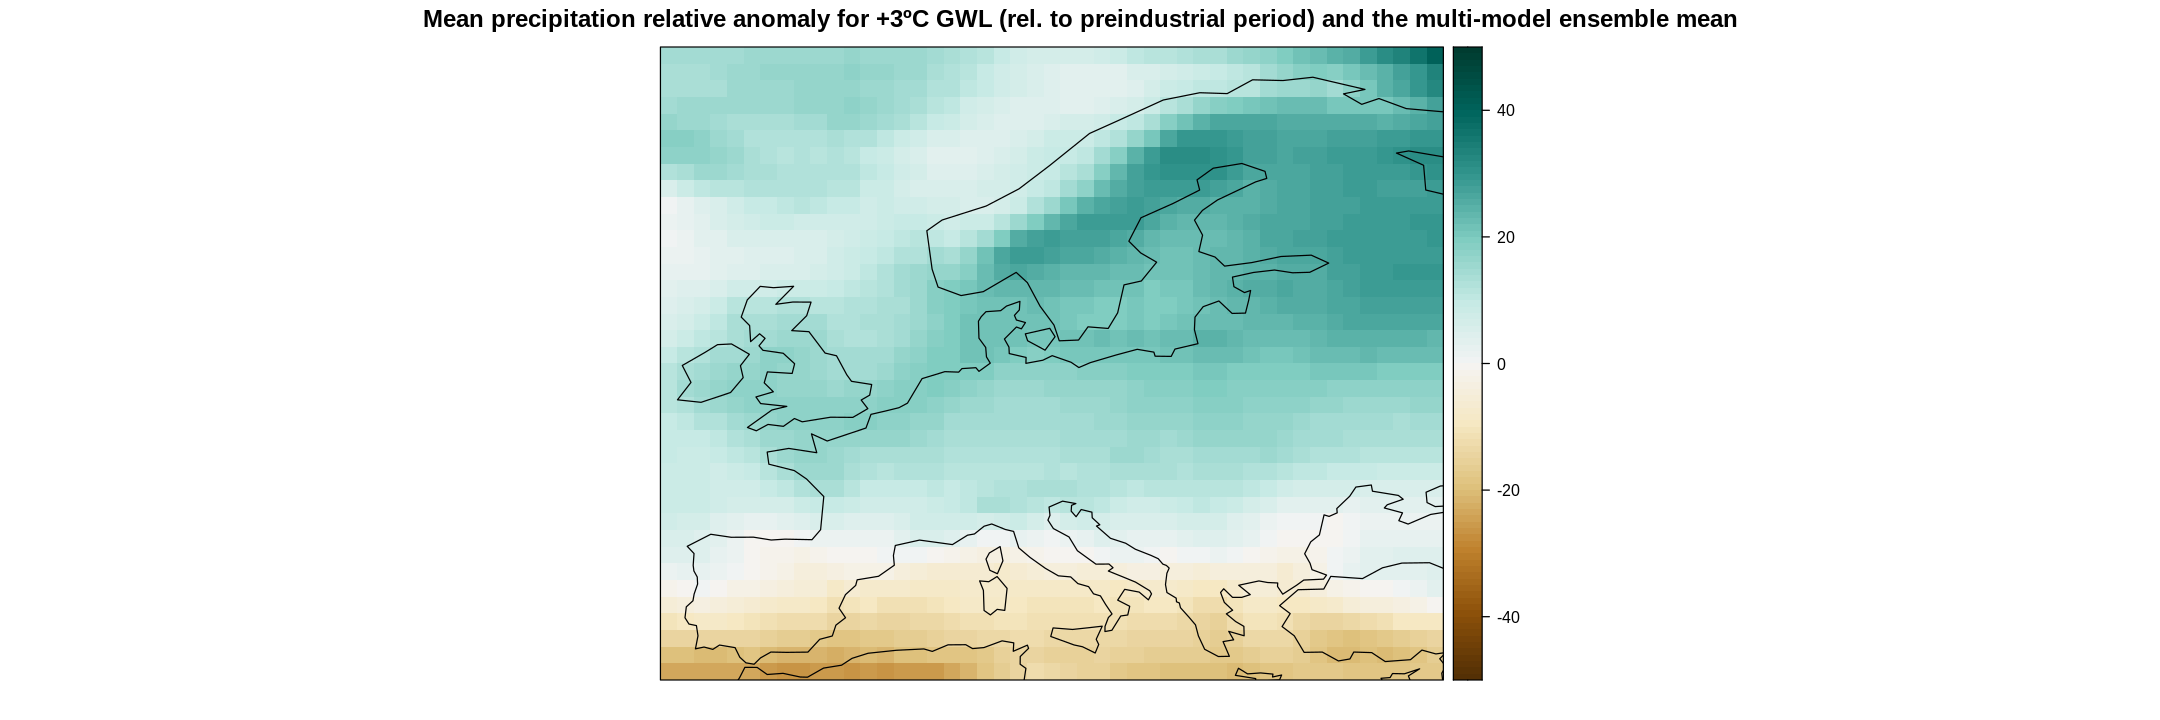

In [27]:
spatialPlot(ens.mean, 
            backdrop.theme = "coastline", 
            at = seq(-50, 50, 1), 
            set.max = 50, set.min = -50, 
            color.theme = "BrBG",
            main = "Mean precipitation relative anomaly for +3ºC GWL (rel. to preindustrial period) and the multi-model ensemble mean")

### 5. Uncertainty Calculation and Representation

*climate4R* implements the "simple" and "advanced" methods for uncertainty characterization defined in the IPCC Sixth Assessment Report. The function to apply is `computeUncertainty`. Please refer to the **AR6 WGI Cross-Chapter Box Atlas 1** ([Gutiérrez et al., 2021](https://www.ipcc.ch/report/ar6/wg1/chapter/atlas/)) for more information.

In this example, we will use the 'simple' method.

[2024-11-07 17:37:44.721551] - Aggregating members...

[2024-11-07 17:37:44.748881] - Done.



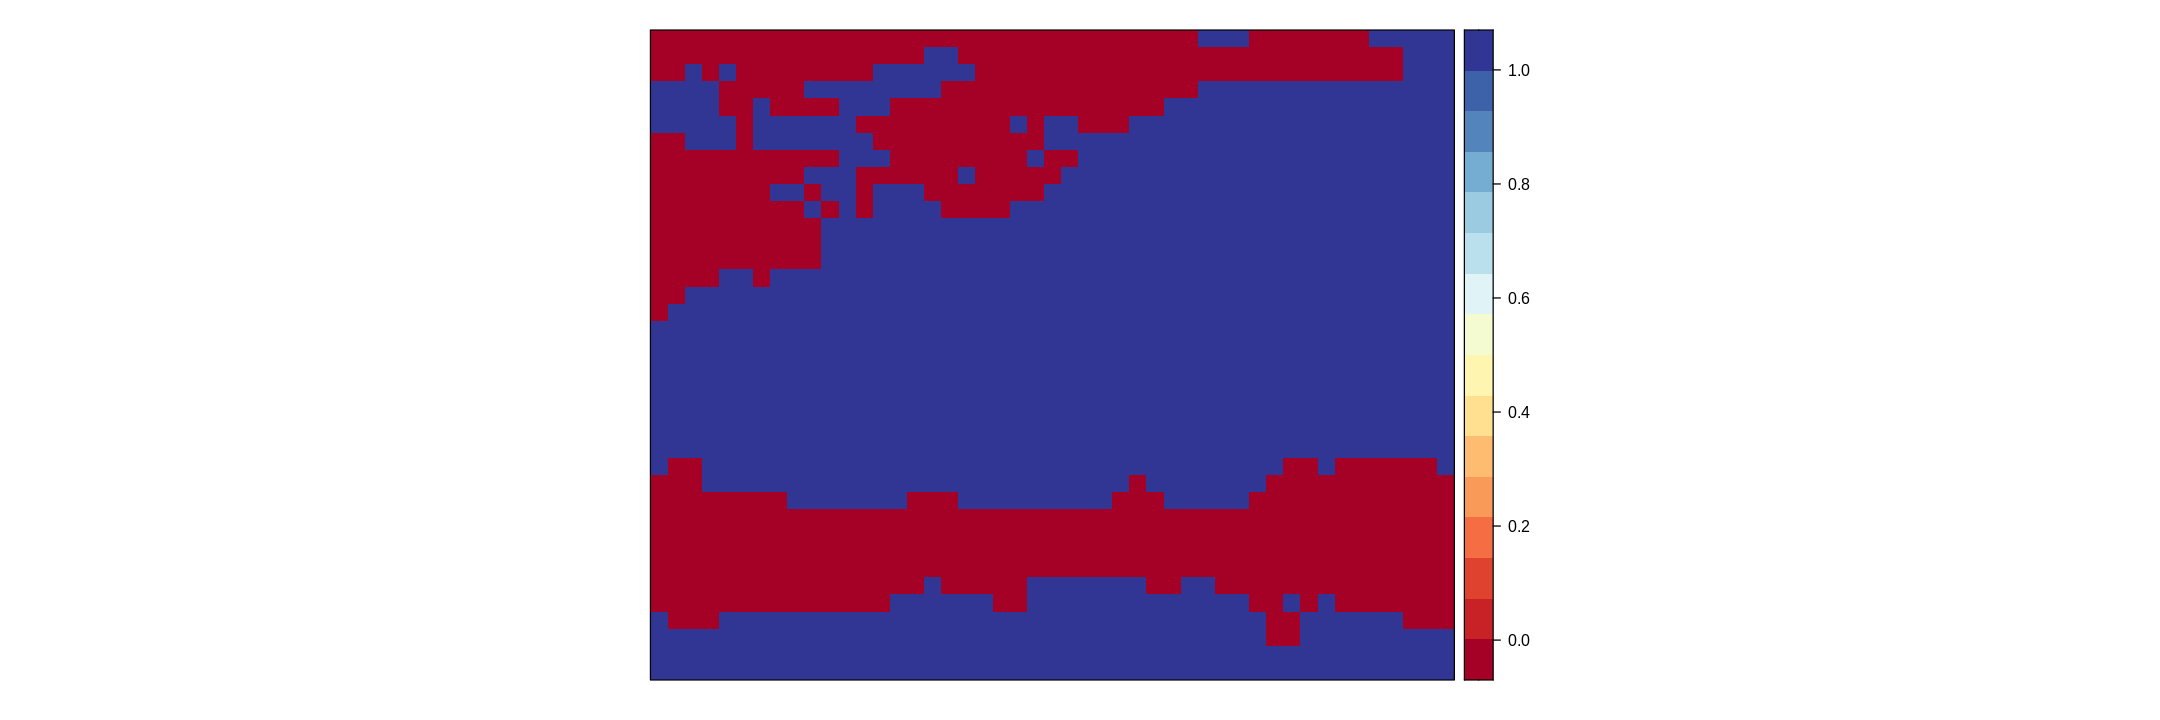

In [28]:
uncert <- computeUncertainty(historical = aggregateGrid(cmip6.hist, aggr.y = list(FUN = "mean")), 
                             anomaly = delta, 
                             method = "simple") 
spatialPlot(uncert)

The outcome yields a binary grid, readily convertible into a vectorial spatial object representing hatches. To achieve this transformation, utilize the `map.hatching` function. This function verifies a particular attribute within the grid, confirming its status as a "climatology" and ensuring that the length of the time dimension is 1. While our grid does not strictly meet the criteria of a climatology, its time dimension is singular. Therefore, we can successfully employ the function by applying the `climatology` function to our uncert object, as the values of the object remain the same.

In [29]:
cat1 <- map.hatching(clim = uncert %>% climatology, 
                     condition = "LT", 
                     threshold = 1, 
                     density = 1) %>% suppressMessages

The newly created object (`cat1`) is a list containing a `SpatialLines` object from the `sp` R package. It also includes other plotting parameters, which can be fine-tuned within the `map.hatching` function. This object can be added as a layer to our map using the `sp.layout` parameter, placing it inside a list, as this parameter allows for the addition of multiple spatial layers.

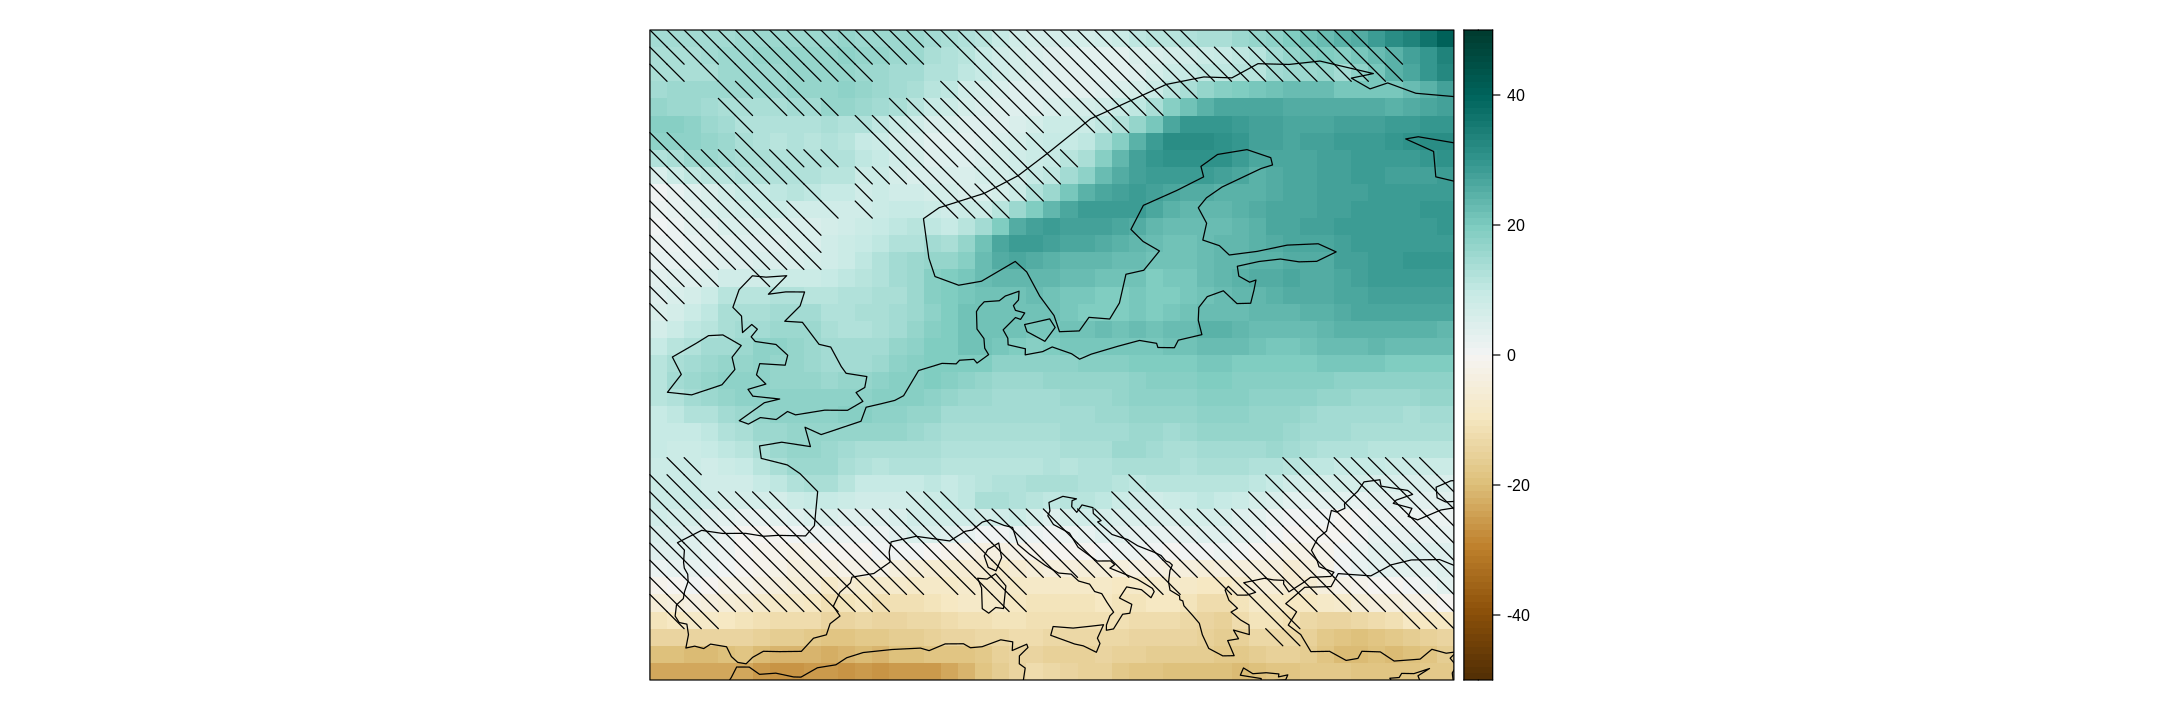

In [30]:
spatialPlot(ens.mean,
            backdrop.theme = "coastline",
            sp.layout = list(cat1),
            color.theme = "BrBG",
            set.min = -50, set.max = 50,
            at = seq(-50, 50, 1))

### Session Info

In [31]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/zequi/miniconda3/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

time zone: Europe/Madrid
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3  magrittr_2.0.3      lattice_0.22-6     
 [4] rgdal_1.6-7         sp_2.1-4            geoprocessoR_0.2.2 
 [7] visualizeR_1.6.4    transformeR_2.2.2   loadeR_1.8.2       
[10] cl